#### Imports

In [329]:
%matplotlib inline
import matplotlib.pyplot as plt

from numpy.matlib import repmat
import cvxpy as cvx
import gurobipy as grb
import scipy.optimize

import networkx as nx
import numpy as np
import scipy as sp
from scipy.sparse import rand
from itertools import combinations
from scipy.sparse import csr_matrix

### Data Generation

In [330]:
np.random.seed(42)

def generate_adj_matrix(people_number, fill_factor = 0.5, triangularity = 0):
    fill_coeff = int(people_number * fill_factor)
    adj_matrix = sp.sparse.rand(people_number,
                                people_number,
                                density = fill_factor,
                                format = 'csr',
                                random_state = np.random.randint(1))

    adj_matrix = adj_matrix.todense()
    adj_matrix[np.arange(people_number), np.arange(people_number)] = 0
    adj_matrix = adj_matrix - adj_matrix.T
    if triangularity > 0:
        adj_matrix[adj_matrix < 0] = 0
    
    return csr_matrix(adj_matrix)

def find_distribution(adj_matrix):

    debtors = []
    creditors = []
    neutrals = []
    d = []
    c = []
    n = []

    for i in range(adj_matrix.shape[0]):
        row_sum = adj_matrix[i, :].sum()

        if row_sum > 0:
            debtors.append(i)
            d.append(row_sum)
        elif row_sum == 0:
            neutrals.append(i)
            n.append(row_sum)
        else:
            creditors.append(i)
            c.append(-row_sum)

    nmb_debt = len(debtors)
    nmb_cred = len(creditors)

    debtors = np.array(debtors)
    creditors = np.array(creditors)
    d = np.array(d)
    c = np.array(c)
    
    return debtors, creditors, neutrals, d, c, n

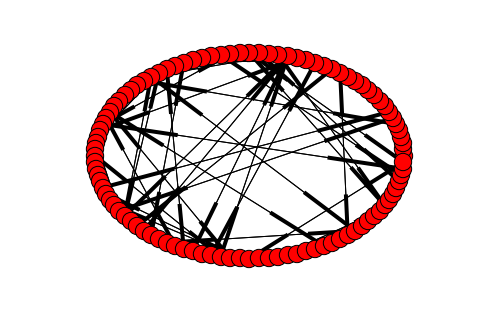

In [70]:
import matplotlib.pyplot as plt 
%matplotlib inline

G = nx.DiGraph(generate_adj_matrix(100, 0.005))

nx.draw_circular(G)

### Mixed Integer Problem

* Let $I$ be the set of people who still must pay money. 
* Let $J$ be the set of people who still must receive money.
* Let $d_i$ be a constant representing the amount of money person $i$ must pay (where $i \in I$).
* Let $c_j$ be a constant representing the amount of money person $j$ must receive (where $j \in J$).
* Let $x_{ij} \in [0, 1]$ be a decision variable representing the persentage of total debt $d_i$ person $i$ pays to person $j$.

Example: player $1$ owes $10$, then $x_{12}=0.75$ would mean person $1$ pays person $2$ $7.50$.

* Let $y_{ij} \in \{0, 1\}$ represent whether person $i$ made a transaction with person $j$ (where $i \in I$ and $j \in J$). The variable takes on value 1 if a transaction was made and 0 otherwise.
* Objective is to minimize the total number of transactions:

\begin{equation*}
\begin{aligned}
& \underset{i \in I, j \in J}{\text{minimize}}
& & \sum_{i \in I, j \in J} y_{ij} \\
& s.t. 
& &  \sum_{j \in J} x_{ij} = 1 \ \forall i \in I \\
& & & \sum_{i \in I} d_i * x_{ij} = c_j \ \forall j \in J \\
& & & x_{ij} \leq y_{ij}
\end{aligned}
\end{equation*}

* First constraint is that each person who owes money pays exactly what they owe:

$$\sum_{j \in J} x_{ij} = 1 (\forall i \in I)$$
* Second constraint is that each person who must receive money gets the exact amount they're supposed to receive:

$$\sum_{i \in I} d_i * x_{ij} = c_j (\forall j \in J)$$
* Last constraint relates the $x$ and $y$ decision variables. That is, it defines what it means for a transaction to occur between $i$ and $j$. A transaction occurs if and only if $i$ pays some nonzero amount to $j$ (i.e., $x_{ij} > 0$):

$$ x_{ij} > 0 \Rightarrow y_{ij} = 1 $$

In another words:
$$x_{ij} \leq y_{ij}$$

In [331]:
"""Mixed Integer Problem"""

def MIPSolver(d,c):
    X = cvx.Variable(len(d), len(c))
    Y = cvx.Bool(len(d), len(c))


    objective = cvx.Minimize(cvx.sum_entries(Y))

    constraints = [X >=0, X <= Y, Y <= 1, Y >= 0]
    #constraints.append(X.T*d.T == c.T)

    for i in range(len(d)):
        constraints.append(cvx.sum_entries(X[i,:]) == 1)
    for j in range(len(c)):
        constraints.append((d.T * X)[j] == c[j])



    solution = cvx.Problem(objective, constraints)
    solution.solve(solver = "GUROBI")
    
    nmb_operations = solution.value
    
    return nmb_operations, Y.value, X.value

def PlotGraph(adj_matrix):
    
    G = nx.DiGraph(adj_matrix)
    plt.figure(figsize=(5,3))
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G,pos)
    nx.draw_networkx_edges(G,pos)
    nx.draw_networkx_labels(G,pos)
    #nx.draw_networkx_edge_labels(G,pos)
    plt.show()

### Test for 3

  (0, 1)	5.0
  (1, 2)	5.0


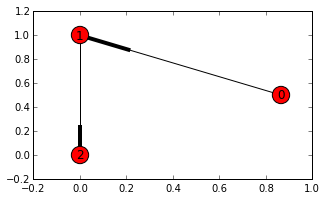

In [332]:
adj_matrix = np.zeros((3,3))
adj_matrix[0,1] = 5
adj_matrix[1,2] = 5
adj_matrix = csr_matrix(adj_matrix)
print adj_matrix
#adj_matrix = adj_matrix - adj_matrix.T
PlotGraph(adj_matrix)

In [334]:
adj_matrix = np.zeros((3,3))
adj_matrix[0,1] = 5
adj_matrix[1,2] = 5
adj_matrix = csr_matrix(adj_matrix)
adj_matrix = adj_matrix - adj_matrix.T

print adj_matrix

debtors, creditors, neutrals, d, c, n = find_distribution(adj_matrix)

print "\nDeptors:", debtors, d
print "Creditors:", creditors, c
print "Neutrals:", neutrals, n

  (0, 1)	5.0
  (1, 0)	-5.0
  (1, 2)	5.0
  (2, 1)	-5.0

Deptors: [0] [ 5.]
Creditors: [2] [ 5.]
Neutrals: [1] [0.0]


In [335]:
nmb_operations, Y, X = MIPSolver(d,c)

print('Optimal value is: {0}'.format(nmb_operations))
print("Y \n {0}".format(Y))
print("X \n {0}".format(X))

Optimal value is: 1.0
Y 
 1.0
X 
 1.0


### Test for 20

Transactions number 20


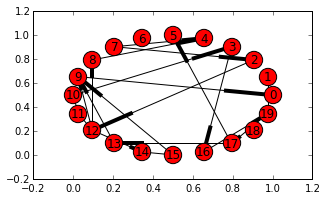

In [340]:
people_number = 20
adj_matrix = generate_adj_matrix(people_number, fill_factor = 0.05, triangularity = 1)
nmb_transactions = len(sp.sparse.find(adj_matrix)[0])
print "Transactions number", nmb_transactions
PlotGraph(adj_matrix)

In [341]:
people_number = 20
adj_matrix = generate_adj_matrix(people_number, fill_factor = 0.05, triangularity = 0)
debtors, creditors, neutrals, d, c, n = find_distribution(adj_matrix)

print "Debtors number", len(d)
print "Creditors number", len(c)
print "Neutrals number", len(n)

Debtors number 7
Creditors number 11
Neutrals number 2


In [ ]:
new_nmb_transactions, Y, X = MIPSolver(d,c)

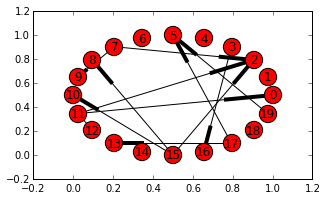

In [312]:
#print('Optimal number of transactions is: {0}'.format(nmb_transactions))
#print("X \n {0}".format(csr_matrix(X)))

#print ("X*d \n {0}".format(csr_matrix(d.transpose()*X)))
#print("X \n {0}".format(X))


T = np.zeros(X.shape)
for i in range (len(d)):
    T[i,:] = X[i,:] * d[i]
new_adj_matrix = np.zeros((people_number, people_number))

for i in range (T.shape[0]):
    for j in range (T.shape[1]):

        if T[i,j] > 0:
            new_adj_matrix[debtors[i], creditors[j]] = T[i,j]

new_adj_matrix= csr_matrix(new_adj_matrix)

            
G = nx.DiGraph(new_adj_matrix)
plt.figure(figsize=(5,3))
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)
#nx.draw_networkx_edge_labels(G,pos)
plt.show()